In [47]:
%matplotlib inline

from dask.distributed import Client
import dask.dataframe as dd
import matplotlib.pyplot as plt
import joblib
import numpy as np
import pandas as pd

In [2]:
# Start and connect to local client

client = Client(n_workers=4)
# client = Client("scheduler-address:8786")  # connecting to remote cluster

In [3]:
client

Client Scheduler: tcp://127.0.0.1:45443 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 15.64 GiB


# 1. Data Preparation

## a) Load Data

In [4]:
# Read in files

In [49]:
def read_file(filepath):
    df = dd.read_csv(filepath, sep = ',', header = None)
    df.columns = ['subject_id', 'activity_code', 'timestamp', 'x_coord', 'y_coord', 'z_coord']
    df['timestamp_dt'] = dd.to_datetime(df['timestamp'])
    df['z_coord'] = df['z_coord'].str.replace(";","").astype('float64') # remove ; and ensure float (having issues with lineterminator)
    return df

In [50]:
# phone data
phone_accel_df = read_file('wisdm-dataset/raw/phone/accel/*.txt')
phone_gyro_df = read_file('wisdm-dataset/raw/phone/gyro/*.txt')

# watch data
watch_accel_df = read_file('wisdm-dataset/raw/watch/accel/*.txt')
watch_gyro_df = read_file('wisdm-dataset/raw/watch/gyro/*.txt')

In [51]:
watch_gyro_df.dtypes

subject_id                int64
activity_code            object
timestamp                 int64
x_coord                 float64
y_coord                 float64
z_coord                 float64
timestamp_dt     datetime64[ns]
dtype: object

## b) Exploratory Data Analysis

In [7]:
def plot_subject_activity(df, title_append=None):
    subject_id = df.head(1)['subject_id'][0]
    activity_code = df.head(1)['activity_code'][0]
    title = f'Subject {subject_id} Performing Activity {activity_code}' 
    if title_append != None:
        title+=str(f' ({title_append})')
        
    fig, ax = plt.subplots(3, figsize=(20,10))
    fig.suptitle(title)
    ax[0].plot(range(len(df)), df['x_coord'].compute().to_numpy())
    ax[0].set_title('x_coord')
    ax[1].plot(range(len(df)), df['y_coord'].compute().to_numpy())
    ax[1].set_title('y_coord')
    ax[2].plot(range(len(df)), df['z_coord'].compute().to_numpy())
    ax[2].set_title('z_coord')
    ax[2].set_xlabel('Interval')

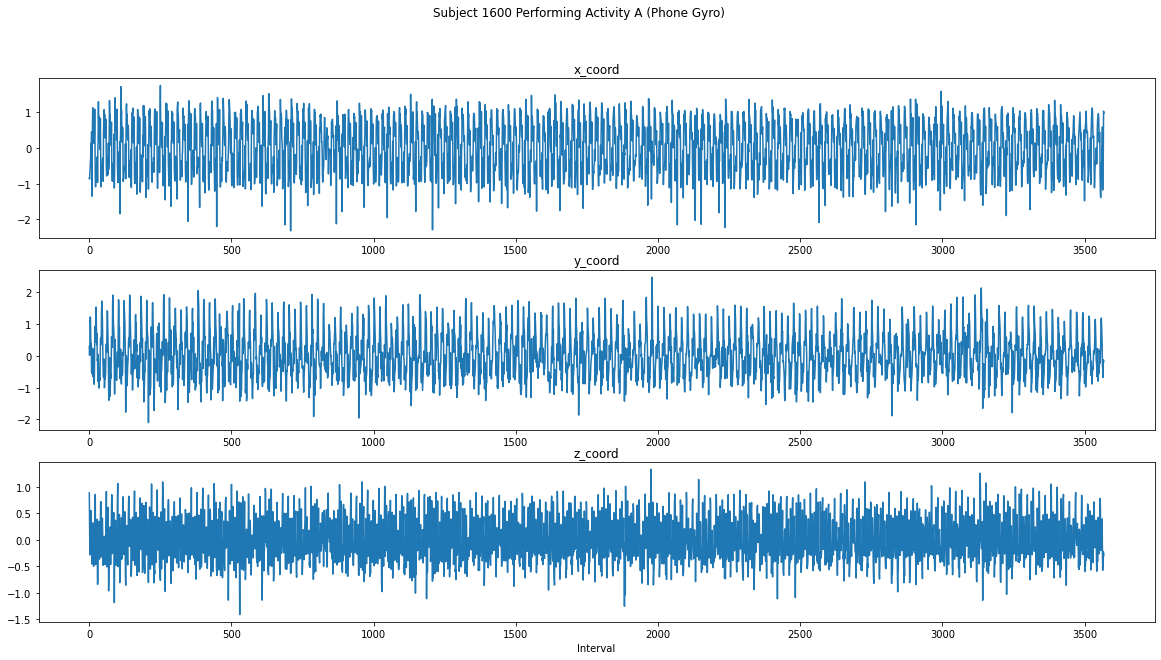

In [8]:
temp = phone_gyro_df[(phone_gyro_df['subject_id'] == 1600) & (phone_gyro_df['activity_code'] == 'A')]
plot_subject_activity(temp, 'Phone Gyro')

In [9]:
print(f'len(phone_accel_df):\t{len(phone_accel_df)}')
print(f'len(phone_gyro_df):\t{len(phone_gyro_df)}')
print(f'len(watch_accel_df):\t{len(watch_accel_df)}')
print(f'len(watch_gyro_df):\t{len(watch_gyro_df)}')

len(phone_accel_df):	4804403
len(phone_gyro_df):	3608635
len(watch_accel_df):	3777046
len(watch_gyro_df):	3440342


Row counts match description within the provided documentation. That being said, intuitively, one might think there would be equal size accelerometer and gyroscope data for each respective device, but that is not the case. If we want to use the different device sensor data in conjunction, we will have to ensure an equal amount of rows (len(phone_accel_df) == len(phone_gyro_df)). We will attempt to join on the timestamps to accomplish this.

In [10]:
phone_accel_sub_act_interval_counts = phone_accel_df.groupby(['subject_id', 'activity_code']).size().rename('count').reset_index()
len(phone_accel_sub_act_interval_counts)
# Expected result if all subjects performed all activities: 51 x 18 = 918

910

In [11]:
phone_gyro_sub_act_interval_counts = phone_gyro_df.groupby(['subject_id', 'activity_code']).size().rename('count').reset_index()
len(phone_gyro_sub_act_interval_counts)
# Expected result if all subjects performed all activities: 51 x 18 = 918

908

In [12]:
phone_accel_sub_act_counts = phone_accel_sub_act_interval_counts.groupby('subject_id').size().rename('activity_count').reset_index()
phone_accel_sub_act_counts[phone_accel_sub_act_counts['activity_count'] < 18].compute()
# Our slackers that didn't perform all 18 activities with phone accel

,subject_id,activity_count
7,1607,17
9,1609,17
16,1616,16
18,1618,17
42,1642,16
43,1643,17


In [13]:
phone_gyro_sub_act_counts = phone_gyro_sub_act_interval_counts.groupby('subject_id').size().rename('activity_count').reset_index()
phone_gyro_sub_act_counts[phone_gyro_sub_act_counts['activity_count'] < 18].compute()
# Our slackers that didn't perform all 18 activities with phone gyro

,subject_id,activity_count
7,1607,17
9,1609,17
16,1616,16
18,1618,17
41,1641,17
42,1642,16
43,1643,17
44,1644,17


Additional Takeaways:
- Not all subjects performed all activities with phone sensors
- Some subjects may have performed certain activities with only 1 of the phone sensors

In [14]:
# Join gyroscope and accelerometer data by device

In [59]:
# Timestamps between sensors not guaranteed to be "perfectly" aligned
combined_phone_df = phone_accel_df.merge(phone_gyro_df, on=["subject_id","timestamp_dt"], how="inner", suffixes=['_accel', '_gyro'])
combined_phone_df.head()

,subject_id,activity_code_accel,timestamp_accel,x_coord_accel,y_coord_accel,z_coord_accel,timestamp_dt,activity_code_gyro,timestamp_gyro,x_coord_gyro,y_coord_gyro,z_coord_gyro
0,1600,A,252211141237052,-2.237320,2.702225,0.155975,1970-01-03 22:03:31.141237052,A,252211141237052,-0.509430,1.401108,-0.165039
1,1600,A,252213105043204,-1.374573,1.647736,-0.874573,1970-01-03 22:03:33.105043204,A,252213105043204,-0.121078,1.767166,0.031235
2,1600,A,252213608583243,-0.703796,3.909042,-0.170883,1970-01-03 22:03:33.608583243,A,252213608583243,1.073990,-0.890411,0.424530
3,1600,A,252214011415274,1.784363,7.609360,-0.033951,1970-01-03 22:03:34.011415274,A,252214011415274,-0.856613,0.571091,-0.273727
4,1600,A,252214061769278,-0.943817,3.754120,-0.521286,1970-01-03 22:03:34.061769278,A,252214061769278,-0.523682,1.739761,-0.150848


In [60]:
# If 0, then very likely timestamps aligned; no mismatches of activity_codes between sensors
(combined_phone_df['activity_code_accel'] != combined_phone_df['activity_code_gyro']).sum().compute()

0

In [62]:
# Cleanup columns
combined_phone_df = combined_phone_df.drop(['activity_code_gyro', 'timestamp_gyro'], axis=1)
combined_phone_df = combined_phone_df.rename(columns={'activity_code_accel': 'activity_code', 'timestamp_accel': 'timestamp'})
combined_phone_df.head()

,subject_id,activity_code,timestamp,x_coord_accel,y_coord_accel,z_coord_accel,timestamp_dt,x_coord_gyro,y_coord_gyro,z_coord_gyro
0,1600,A,252211141237052,-2.237320,2.702225,0.155975,1970-01-03 22:03:31.141237052,-0.509430,1.401108,-0.165039
1,1600,A,252213105043204,-1.374573,1.647736,-0.874573,1970-01-03 22:03:33.105043204,-0.121078,1.767166,0.031235
2,1600,A,252213608583243,-0.703796,3.909042,-0.170883,1970-01-03 22:03:33.608583243,1.073990,-0.890411,0.424530
3,1600,A,252214011415274,1.784363,7.609360,-0.033951,1970-01-03 22:03:34.011415274,-0.856613,0.571091,-0.273727
4,1600,A,252214061769278,-0.943817,3.754120,-0.521286,1970-01-03 22:03:34.061769278,-0.523682,1.739761,-0.150848


In [68]:
combined_phone_df.set_index('timestamp_dt').groupby(['subject_id', 'activity_code', pd.Grouper(freq='3S')]).size().head() # 3S = 3 seconds

subject_id  activity_code  timestamp_dt       
1611        F              1970-01-01 00:19:21    30
                           1970-01-01 00:19:24    59
                           1970-01-01 00:19:27    60
                           1970-01-01 00:19:30    59
                           1970-01-01 00:19:33    60
dtype: int64

In [ ]:
combined_watch_df = watch_accel_df.merge(watch_gyro_df, on=["subject_id","timestamp"], how="inner")
combined_watch_df.compute()

In [ ]:
# Group by subject id, activity, time interval window (3s) - mean, std x, y, z with group by

# https://stackoverflow.com/questions/35898667/group-by-time-and-other-column-in-pandas

In [ ]:
# Join back together for single dataframe 

# 2. Model Selection & Training

In [ ]:
# train test split
# fit model
# hyperparamter tuning depending on model selected (if time permits)

# 3. Model Test

In [ ]:
# test /validate and provide final accurracy 

# 4. Results & Conclusion

In [ ]:
# Summarize final results and conclusion - reinclude any helpful charts/graphs

In [ ]:
client.shutdown()